# Identification Eire Lake water level

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Proyecto_Splra')

In [ ]:
!pip install scikit-build
!pip install setuptools_scm
!pip install control -U
!pip install scienceplots
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended texlive-latex-recommended cm-super
!pip install statsforecast

## Data pre-processing

In [4]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import numpy as np
import control as ctl
import scipy.linalg as la
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#plt.style.use('fivethirtyeight')
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['savefig.dpi'] = 800

In [5]:
import sys
sys.path.append("/content/drive/MyDrive/Proyecto_Splra/Python")

In [6]:
from Lra_Modeling import *
from Sparse_Sys_Id import *
from Sparse_Lra import *

from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
df=pd.read_csv('/content/drive/MyDrive/Proyecto_Splra/Data/monthly-lake-erie-levels-1921-19.csv')
df=df.dropna(how='any',axis=0)
df.rename(columns={'Month':'Date','Monthly Lake Erie Levels 1921 ? 1970,':'Level'},inplace='True')
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)

In [9]:
df.head()

,Level
Date,
1921-01-01,14.763
1921-02-01,14.649
1921-03-01,15.085
1921-04-01,16.376
1921-05-01,16.926


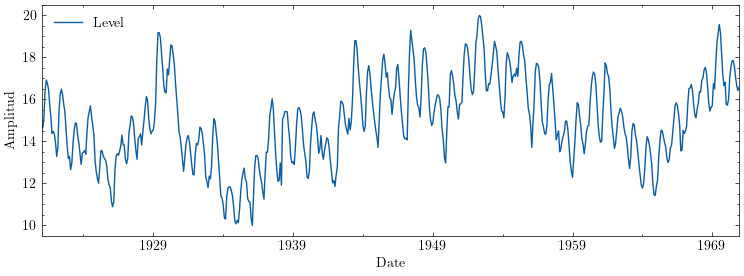

In [10]:
with plt.style.context(['science']):
    df.plot(figsize=(9,3))
    plt.ylabel('Amplitud')
    #plt.savefig('erie01.png')
    plt.show()

In [11]:
Xd = signal.detrend(df.values.T)
Xs = (Xd-np.mean(Xd))/np.std(Xd)

In [12]:
df_s=pd.DataFrame(Xs.T,df.index,df.columns)

## Identification and validation split

In [13]:
pct_test=0.30
ntest=int(pct_test*len(df))
train,test=df_s[:-ntest],df_s[-ntest:]

In [14]:
dates=df.index

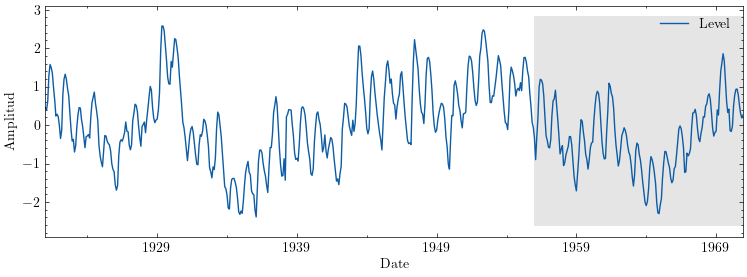

In [15]:
with plt.style.context(['science']):
    df_s.plot(figsize=(9,3))
    plt.ylabel('Amplitud')

    ylim = plt.ylim()
    plt.fill_between(dates[-ntest:], ylim[0], ylim[1], facecolor='k', alpha=0.1);
    #plt.savefig('erie02.png')
    plt.show()

## Splra

In [16]:
Xtrain,Xtest=train.values.reshape(1,len(train)),test.values.reshape(1,len(test))

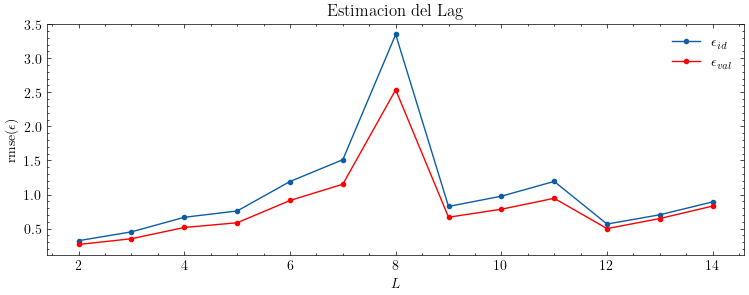

In [18]:
lag_est_ar(Xtrain,Xtest,15,1e-2,1e-2)

In [20]:
L=3

In [21]:
x,x_sp,R_sp,H,Dh,Xp,error = Ar_Model_lra(Xtrain,L,1e-2,1e-2)

In [22]:
np.mean(error),np.std(error),np.var(error),rmse(Xtrain[:,L:],Xp,axis=1)

(-0.00025965532688123645,
 0.45301825799683776,
 0.20522554207848948,
 array([0.0292309]))

In [23]:
x_sp

array([[ 1.00011867, -2.59808662,  2.597621  ]])

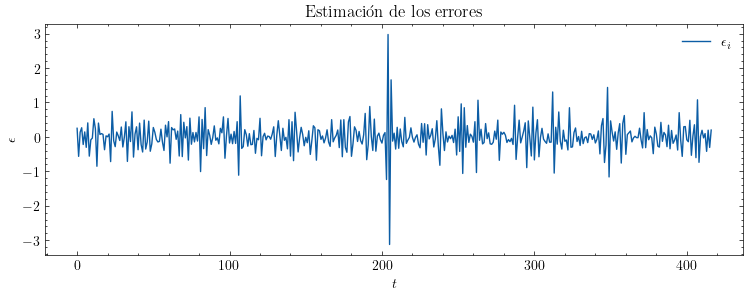

In [24]:
with plt.style.context(['science']):

      plt.figure(figsize=(9,3))
      plt.plot(error.T,label='$\epsilon_{i}$')

      plt.title('Estimación de los errores')
      plt.xlabel('$t$')
      plt.ylabel('$\epsilon$')
      plt.legend()
      #plt.savefig('erie04.png')

      plt.show()

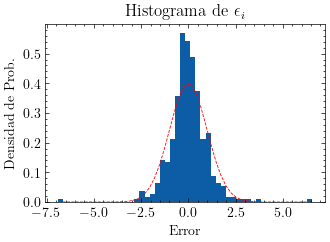

In [25]:
mu = 0
sigma = 1
num_bins=50

fig, ax = plt.subplots()

n, bins, patches = ax.hist(error.T/np.std(error), num_bins, density=True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--',color='r')
ax.set_xlabel('Error')
ax.set_ylabel('Densidad de Prob.')
ax.set_title(r'Histograma de $\epsilon_i$')
plt.savefig('erie05.png')
fig.tight_layout()

plt.show()

In [26]:
import statsmodels.api as sm

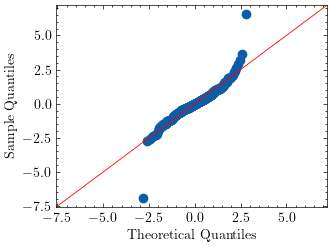

In [27]:
fig = sm.qqplot(error[0,:]/np.std(error),line="45")
plt.savefig('erie06.png')
plt.show()

In [28]:
w = np.block([[error],[Xtrain[:,L:]]])

In [29]:
w.shape

(2, 417)

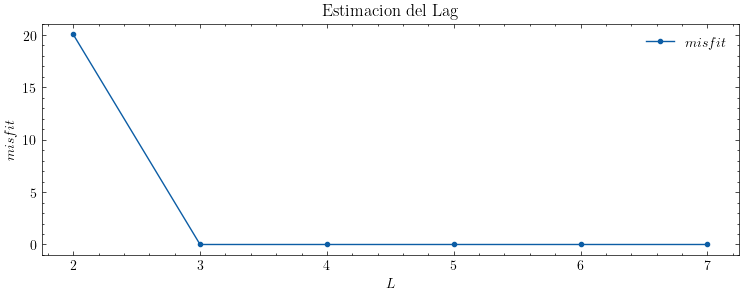

In [30]:
lag_est(w,8,1,x0=1,tol=1e-3,delta=1e-3)

In [31]:
M,fit,wh,R_sp,sys_tf,sys_ss,x0 = Sparse_lra_sysid(w,3,1, x0 = 1, tol=1e-3 , delta=1e-3)

In [32]:
M,fit

(1.4546478798153712e-12, 99.99999999999368)

In [33]:
sys_tf

TransferFunction(array([1., 0., 0., 0.]), array([ 1.        , -2.597621  ,  2.59808662, -1.00011867]), 1)

In [34]:
sys_ss

<LinearIOSystem:sys[15]:['u[0]']->['y[0]']>

(array([0.999138 +0.j      , 0.7992415+0.601826j, 0.7992415-0.601826j]),
 array([0.+0.j, 0.+0.j, 0.+0.j]))

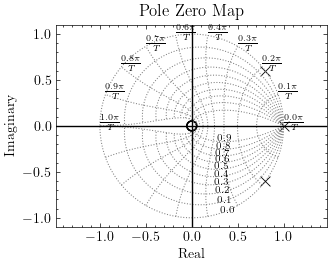

In [35]:
ctl.pzmap(sys_tf,grid=True)
#plt.savefig('erie07.png')

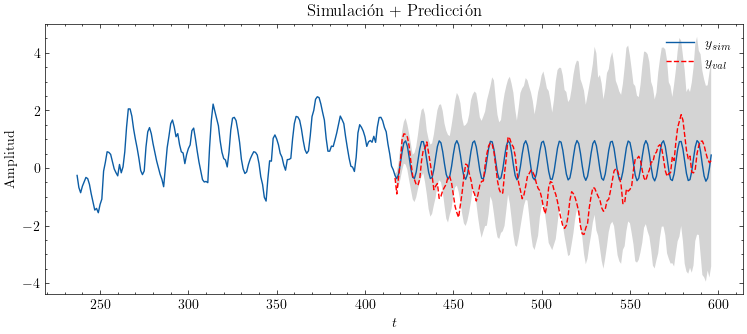

In [37]:
t,Yfcast = Ar_lra_forecast(sys_ss,Xtrain,Xtest,error,x0,np.std(error)/np.sqrt(Xtrain.shape[1]),10000,len(test),0)

## AutoArima

In [38]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, MSTL

In [40]:
df=pd.read_csv('/content/drive/MyDrive/Proyecto_Splra/Data/monthly-lake-erie-levels-1921-19.csv')
df=df.dropna(how='any',axis=0)
df.rename(columns={'Month':'ds','Monthly Lake Erie Levels 1921 ? 1970,':'y'},inplace='True')

In [41]:
data_sf=df.copy()

In [42]:
data_sf['ds']=pd.to_datetime(data_sf['ds'])
data_sf['unique_id']='EirieLake'

In [43]:
data_sf.head()

,ds,y,unique_id
0,1921-01-01,14.763,EirieLake
1,1921-02-01,14.649,EirieLake
2,1921-03-01,15.085,EirieLake
3,1921-04-01,16.376,EirieLake
4,1921-05-01,16.926,EirieLake


In [44]:
sf = StatsForecast(
    models = [AutoARIMA(season_length = 12)],
    freq = 'M'
)

In [45]:
train_sf,test_sf=data_sf[:-ntest],data_sf[-ntest:]

In [46]:
sf.fit(train_sf)

StatsForecast(models=[AutoARIMA])

In [48]:
forecast_df = sf.predict(h=len(test_sf), level=[95])

forecast_df.tail()

,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
unique_id,,,,
EirieLake,1970-07-31,17.099161,14.943727,19.254595
EirieLake,1970-08-31,16.437927,14.282320,18.593536
EirieLake,1970-09-30,15.857245,13.701540,18.012951
EirieLake,1970-10-31,15.313453,13.157682,17.469225
EirieLake,1970-11-30,15.142600,12.986792,17.298407


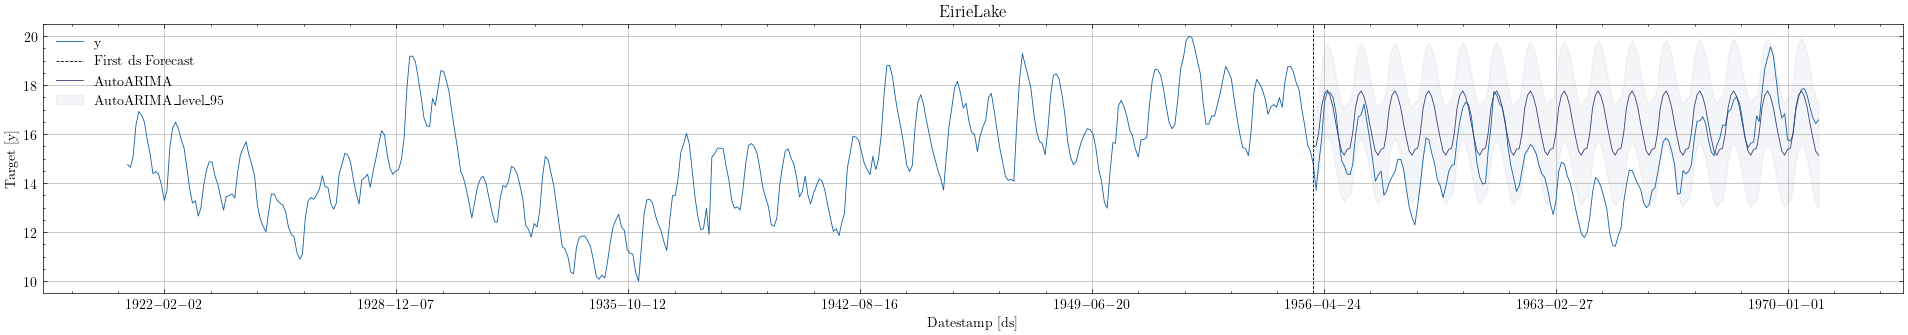

In [49]:
data_sf["ds"]=pd.to_datetime(data_sf["ds"])
sf.plot(data_sf, forecast_df, level=[95])

In [50]:
def mae(y_hat, y_true):
    return np.mean(np.abs(y_hat-y_true))

In [57]:
mae(test_sf['y'].values,forecast_df['AutoARIMA']),mae(Xtest,np.mean(Yfcast,axis=2)[:,:])

(1.5306455163743762, 0.877545142458923)

In [59]:
rmse(test_sf['y'].values,forecast_df['AutoARIMA']),rmse(Xtest,np.mean(Yfcast,axis=2)[:,:],axis=1)

(1.8763999047663216, array([1.11489552]))